# Lambert Solver for Exponential Sinusoids - Example Trajectory
#### Python Proof of Concept - Chris Andre
Unchanging 1 kg spacecraft weight assumed

First, some boilerplate:

In [1]:
# boilerplate
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
from ExpoSinLambert import ExpoSinLambert
from PyKEP import MU_SUN, DAY2SEC, AU
from PyKEP.core import epoch
from PyKEP.planet import jpl_lp
import math
from Vector import *
import matplotlib.pyplot as plt

Define the transfer problem:
(a good example is 0, 26.75*365, earth, saturn, 3, True, 0.1)

In [2]:
start = 0.0 # days
tof = 26.75*365.0 # days
p1 = jpl_lp('earth')
p2 = jpl_lp('saturn')
revs = 3
longway = True
k2 = 0.1 #winding parameter - see footnote

Try to solve the specified problem:

In [3]:
# Finding the solution:
r1, v1 = p1.eph(epoch(start))
r2, v2 = p2.eph(epoch(start + tof))
print 'Trying to find a solution...'
problem = ExpoSinLambert(r1, r2, tof*DAY2SEC, MU_SUN, N=revs, k2=k2, lw=longway)
print 'Success!'

Trying to find a solution...
Success!


Plot the solution it discovered:

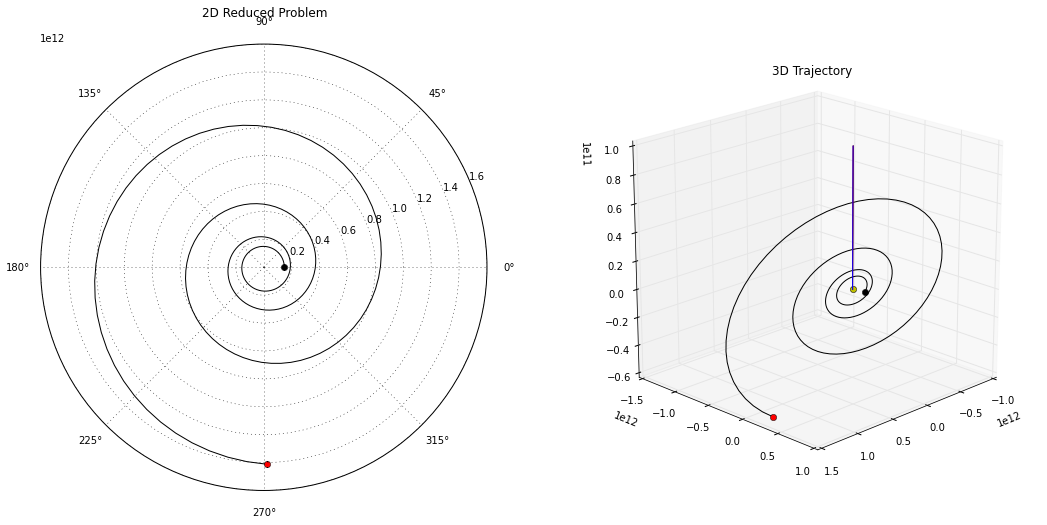

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1, polar=True)
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.view_init(20, 45)
problem.graph2DReduced(ax1)
problem.graph3D(ax2)
ax2.plot([0], [0], [0], 'yo') # sun
ax2.plot([r1[0]], [r1[1]], [r1[2]], 'ko') # start planet
ax2.plot([r2[0]], [r2[1]], [r2[2]], 'ro') # target planet
am1 = scale(unit(cross(r1, v1)), 1.0e11) # visual of start planet angular momentum
am2 = scale(unit(cross(r2, v2)), 1.0e11) # visual of target planet angular momentum
amt = scale(unit(cross(r1, problem.boundaryV()[0])), 1.0e11) # visual of trajectory initial angular momentum
ax2.plot([0, am1[0]], [0, am1[1]], [0, am1[2]], 'k')
ax2.plot([0, am2[0]], [0, am2[1]], [0, am2[2]], 'r')
ax2.plot([0, amt[0]], [0, amt[1]], [0, amt[2]], 'b')
plt.show()

## Additional readouts

In [5]:
# Starting flight path angle
print "%.3f degrees" % (math.atan(problem.tany1) * 180 / math.pi)

0.059 degrees


In [6]:
# Ending flight path angle
print "%.3f degrees" % (math.atan(problem.tany2) * 180 / math.pi)

5.283 degrees


In [7]:
# Starting radius
print '%.4f AU' % (mag(r1) / AU)

0.9833 AU


In [8]:
# Intercept radius
print '%.4f AU' % (mag(r2) / AU)

9.4366 AU


In [9]:
# Traversed angle
print '%i degrees, %.2f radians' % (problem.classExpoSin.psi * 180 / math.pi, problem.classExpoSin.psi)

1350 degrees, 23.58 radians


In [10]:
# Exponential sinusoid that solves the problem
print problem.fittedExpoSin

k0 = 550515192251.8867, k1 = -1.3198, k2 = 0.1000, phi = 1.5785


In [11]:
# Terminal velocity vectors
# Note - if the boundary velocities are unusually high, it is going opposite the planet's velocity
esv1, esv2 = problem.boundaryV()
print 'origin v1 = %.3f km/s' % (mag(v1) / 1000.0)
print 'target v2 = %.3f km/s' % (mag(v2) / 1000.0)
print 'exposin v1 = %.3f km/s' % (mag(esv1) / 1000.0)
print 'exposin v2 = %.3f km/s' % (mag(esv2) / 1000.0)
print 'dv1 = %.3f km/s' % (mag(sub(esv1, v1)) / 1000.0)
print 'dv2 = %.3f km/s' % (mag(sub(esv2, v2)) / 1000.0)

origin v1 = 30.286 km/s
target v2 = 9.746 km/s
exposin v1 = 30.237 km/s
exposin v2 = 9.651 km/s
dv1 = 1.281 km/s
dv2 = 0.407 km/s


In [12]:
# Thrust statistics
impulses = problem.impulses()
print 'max accel = %.8f m/s^2' % impulses[1]
print 'low-thrust impulse = %.2f N-s' % impulses[0]
print 'dv1 impulse = %.2f N-s' % mag(sub(esv1, v1))
print 'dv2 impulse = %.2f N-s' % mag(sub(esv2, v2))
print 'total impulse = %.2f N-s' % (impulses[0]+mag(sub(esv1, v1))+mag(sub(esv2, v2)))

max accel = 0.00013998 m/s^2
low-thrust impulse = 19193.56 N-s
dv1 impulse = 1281.03 N-s
dv2 impulse = 406.95 N-s
total impulse = 20881.54 N-s


####Footnotes
We can establish a range for k2 using Equation 11 of Izzo's paper; it is guaranteed that there are no solutions outside this interval:
$$ k_2 <= \left( \frac{4}{\ln^2 r_1/r_2} \right)^{1/4} $$
The equation admits a more detailed range than this, so you may optimize that if need be.

In [13]:
def k2_simple_range(r1, r2):
    return -math.pow(4/math.log(r1/r2)**2, 0.25), math.pow(4/math.log(r1/r2)**2, 0.25)

def check_k2_possible(k2, r1, r2, psi):
    return 0 <= 2 * (1 - math.cos(k2 * psi)) / k2**4 - math.log(r1 / r2)**2